# Welcome to your very own stock forecaster!!!
This product takes that takes the historical data of a stock and its market index to forecast the stock's future high and lows for the next week. This is used as a tool for financial market traders, these forecasted high and low prices represent your BUY and SELL positions to maximize profit while minimizing risk for your upcoming week.

In [122]:
import pandas as pd
import numpy as np
import sklearn as linear_model
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statistics

## Importing Stock Dataset
Here you import the stock's historical data, a great source for csv files for stocks is yahoo finance. There are a couple of requirements in the submitted dataset for the program to run properly:
- the data set must have the following features: "Open", "High", "Low", "Close", "Volume"
- the data set must have the most recent 20 rows of historical data from the previous 20 weeks for the stock (in order by date)
- the time period per entry must be a week as the forecast is predicting next week's data

In [123]:
file = "META_week.csv" #put stock's csv file name here
Stock_df = pd.read_csv(file)
# clean data set to only have "Open", "High", "Low", "Close", "Volume"
del Stock_df["Date"] #keep for yahoo finance data
del Stock_df["Adj Close"] #keep for yahoo finance data
Stock_df

,Open,High,Low,Close,Volume
0,202.339996,211.320007,190.220001,210.479996,171918600
1,207.679993,213.149994,198.789993,200.059998,150181200
2,200.789993,200.889999,186.110001,187.610001,167510900
3,187.029999,216.800003,185.820007,216.490005,185000200
4,214.500000,225.500000,207.630005,221.820007,157399700
5,222.130005,231.149994,219.539993,224.850006,126967100
6,225.979996,236.860001,218.559998,222.330002,126190000
7,218.419998,222.029999,210.000000,210.179993,78256700
8,210.000000,218.429993,183.270004,184.110001,166088100
9,182.729996,212.479996,169.000000,200.470001,282175400


## Importing Market Index Dataset
Here you import the market index's historical data, a great source for csv files for stocks is yahoo finance. There are a couple of requirements in the submitted dataset for the program to run properly:
- the data set must have the following features: "Open", "Close" (only looking at change in price)
- the data set must have the most recent 20 rows of historical data from the previous 20 weeks for the stock (in order by date)
- the time period per entry must be a week as the forecast is predicting next week's data

In [132]:
file = "NasdaqC_week.csv" #put stock's csv file name here
Index_df = pd.read_csv(file)
# clean data set to only have "Open", "Close" for change in price
del Index_df["Date"] #keep for yahoo finance data
del Index_df["Adj Close"] #keep for yahoo finance data
del Index_df["High"] #keep for yahoo finance data
del Index_df["Low"] #keep for yahoo finance data
del Index_df["Volume"] #keep for yahoo finance data
#extract data for get change in price
Index_returns = []
for ind in Index_df.index:
    open=Index_df['Open'][ind]
    close=Index_df['Close'][ind]
    change=((close-open)/open)*100
    Index_returns.append(change)
#add new column to Stock df
Stock_df = Stock_df.assign(Index_returns=Index_returns)
prediction_inputs = Stock_df.tail(1)
print("The following is the cleaned and transformed data set the program will be using: ")
print()
Stock_df

The following is the cleaned and transformed data set the program will be using: 



,Open,High,Low,Close,Volume,Index_returns
0,202.339996,211.320007,190.220001,210.479996,171918600,2.013204
1,207.679993,213.149994,198.789993,200.059998,150181200,-1.896639
2,200.789993,200.889999,186.110001,187.610001,167510900,-3.635487
3,187.029999,216.800003,185.820007,216.490005,185000200,8.587022
4,214.500000,225.500000,207.630005,221.820007,157399700,2.228726
5,222.130005,231.149994,219.539993,224.850006,126967100,0.594546
6,225.979996,236.860001,218.559998,222.330002,126190000,-4.148036
7,218.419998,222.029999,210.000000,210.179993,78256700,-1.448334
8,210.000000,218.429993,183.270004,184.110001,166088100,-3.604517
9,182.729996,212.479996,169.000000,200.470001,282175400,-3.251430


## Set Up High Forecast Dataframe
This function transforms the given dataframe so each entry has the real future high value of the stock, this is used in the training of the regression line.

In [125]:
#Forecast High Regression Model (dataframe set up)
def High_forecast_df(dataframe):
    '''
    input:
        dataframe - represents the cleaned historical dataframe for the stock 
    return:
        High_forecast_df - the transformed dataframe which has the future high for every entry
    '''
    Future_high = []
    counter = -1
    for ind in dataframe.index:
        counter+=1
        if counter<1:
            continue
        Future_high.append(dataframe['High'][ind])
    Future_high.append(0)
    High_forecast_df = dataframe.assign(Future_High=Future_high)
    High_forecast_df = High_forecast_df.head(High_forecast_df.shape[0] - 1)
    del High_forecast_df['Open']
    return High_forecast_df

#print sample transformed dataframe  
print("here is a sample of how the High forecast trainging data is set using a 10 fold standard of training")
High_f_df = High_forecast_df(Stock_df)
High_f_df

here is a sample of how the High forecast trainging data is set using a 10 fold standard of training


,High,Low,Close,Volume,Index_returns,Future_High
0,211.320007,190.220001,210.479996,171918600,2.013204,213.149994
1,213.149994,198.789993,200.059998,150181200,-1.896639,200.889999
2,200.889999,186.110001,187.610001,167510900,-3.635487,216.800003
3,216.800003,185.820007,216.490005,185000200,8.587022,225.500000
4,225.500000,207.630005,221.820007,157399700,2.228726,231.149994
5,231.149994,219.539993,224.850006,126967100,0.594546,236.860001
6,236.860001,218.559998,222.330002,126190000,-4.148036,222.029999
7,222.029999,210.000000,210.179993,78256700,-1.448334,218.429993
8,218.429993,183.270004,184.110001,166088100,-3.604517,212.479996
9,212.479996,169.000000,200.470001,282175400,-3.251430,224.300003


## Set Up High Forecast Regression Line
This function creates the high forecast regression line for predicting the future high price for the stock.

In [126]:
def Forecast_high_regression(dataframe):
    '''
    input:
        dataframe - represents the transformed high historical dataframe for the stock 
    return:
        High_reg - Returns the trained regression line for high price forecasting
    '''
    High_reg=LinearRegression()
    High_reg.fit(dataframe[['High','Low','Close','Volume','Index_returns']],dataframe.Future_High)
    return High_reg

Forecast_high_reg = Forecast_high_regression(High_f_df)
print("Here is an example of how the formula is created after the first training set")
inputs = ['High','Low','Close','Volume','Index_returns']
index = -1
for input in inputs:
    index +=1
    print(f"{input}: {Forecast_high_reg.coef_[index]}")
print(f"Intercept of the regression line: {Forecast_high_reg.intercept_}")

Here is an example of how the formula is created after the first training set
High: 0.3206637334606764
Low: -0.2033307896033346
Close: 0.866472265674148
Volume: 4.171821668674802e-08
Index_returns: -0.21063101358268269
Intercept of the regression line: -0.16246906872257227


## Set Up Low Forecast Dataframe
This function transforms the given dataframe so each entry has the real future low value of the stock, this is used in the training of the regression line.

In [127]:
#Forecast Low Regression Model (set up dataframe)
def Low_forecast_df(dataframe):
    '''
    input:
        dataframe - represents the cleaned historical dataframe for the stock 
    return:
        Low_forecast_df - the transformed dataframe which has the future low for every entry
    '''
    Future_low = []
    counter = -1
    for ind in dataframe.index:
        counter+=1
        if counter<1:
            continue
        Future_low.append(dataframe['Low'][ind])
    Future_low.append(0)
    Low_forecast_df = dataframe.assign(Future_Low=Future_low)
    Low_forecast_df = Low_forecast_df.head(Low_forecast_df.shape[0] - 1)
    del Low_forecast_df['Open']
    return Low_forecast_df

#print sample transformed dataframe  
print("here is a sample of how the Low forecast trainging data is set using a 10 fold standard of training")
Low_f_df = Low_forecast_df(Stock_df)
Low_f_df

here is a sample of how the Low forecast trainging data is set using a 10 fold standard of training


,High,Low,Close,Volume,Index_returns,Future_Low
0,211.320007,190.220001,210.479996,171918600,2.013204,198.789993
1,213.149994,198.789993,200.059998,150181200,-1.896639,186.110001
2,200.889999,186.110001,187.610001,167510900,-3.635487,185.820007
3,216.800003,185.820007,216.490005,185000200,8.587022,207.630005
4,225.500000,207.630005,221.820007,157399700,2.228726,219.539993
5,231.149994,219.539993,224.850006,126967100,0.594546,218.559998
6,236.860001,218.559998,222.330002,126190000,-4.148036,210.000000
7,222.029999,210.000000,210.179993,78256700,-1.448334,183.270004
8,218.429993,183.270004,184.110001,166088100,-3.604517,169.000000
9,212.479996,169.000000,200.470001,282175400,-3.251430,200.990005


## Set Up Low Forecast Regression Line
This function creates the low forecast regression line for predicting the future low price for the stock.

In [128]:
def Forecast_low_regression(dataframe):
    Low_reg=LinearRegression()
    Low_reg.fit(dataframe[['High','Low','Close','Volume','Index_returns']],dataframe.Future_Low)
    return Low_reg

Forecast_low_reg = Forecast_low_regression(Low_f_df)
print("Here is an example of how the formula is created after the first training set")
inputs = ['High','Low','Close','Volume','Index_returns']
index = -1
for input in inputs:
    index +=1
    print(f"{input}: {Forecast_low_reg.coef_[index]}")
print(f"Intercept of the regression line: {Forecast_low_reg.intercept_}")

Here is an example of how the formula is created after the first training set
High: -0.3994721191150959
Low: -0.1331406900598743
Close: 1.531893688427135
Volume: 6.650908054850468e-08
Index_returns: -0.8970852701784178
Intercept of the regression line: -19.232932578273022


## Low Forecast Training
Here we do the full training for the low forecasting regression line using a 10 fold system. The 10 fold system is when you have a data set of 10 entries and you use 9 to train and 1 as the test data. For understanding the current 10 week's trend accuracy this cell runs the 10 fold training system over the full dataset, it starts with the first 10 and then the regression line restarts with the next 9 and predicts the 11th low price. This continues for the rest of the entries until the program has to predict next week's low and high prices based off the most recent/current week's entry. This allows the trader to understand the accuracy of the regression line in the current trend which is shown in the final product. Below you will see the margin of error mean and standard deviation range along with a plot showing the test data and the regression's predictions.

Regression Accuracy Over the Past 10 Time Periods

mean margin of error: 2.9117739293394664%
standard deviation of error: 5.816136508222837%
Deviation range: -2.904362578883371% - 8.727910437562304%



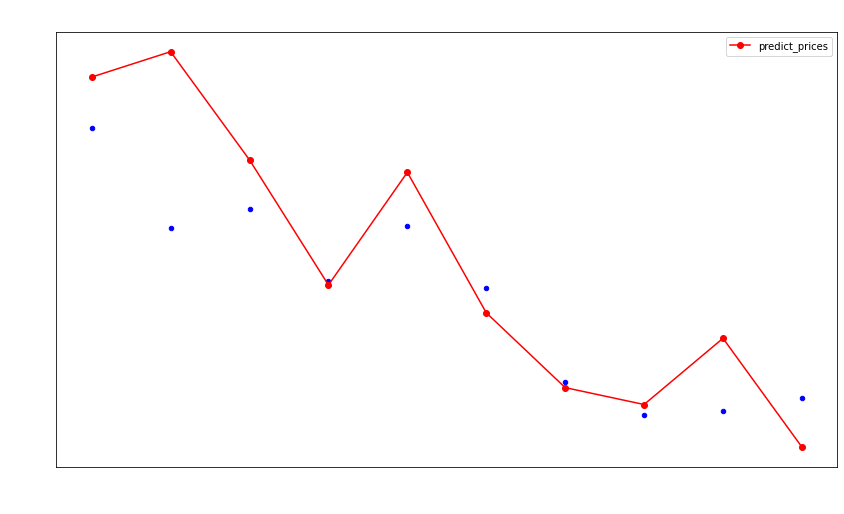

In [129]:
#loop through data set using a 10 fold technique looping 10 times to calculate over test accuracy over the last 10 day trend
counter=0
start=-1
test_values=9
mean_low = 0
lows = []
# define test dictionary for scatter plot
test_low_dic = {}
# define lists for scatter plot
results = []
predicts = []

while counter<10:
    #increase counter and indicies
    counter+=1
    start+=1
    test_values+=1
    # grab training data set 
    train_df = Stock_df.iloc[start:test_values]
    #grab test data for prediction
    predict_test = Stock_df["Low"][test_values]
    #grab prediction inputs
    predict_inputs = train_df.tail(1)
    del predict_inputs["Open"]
    #set low forecast dataframe
    Low_df = Low_forecast_df(train_df)
    #make low forecast regression line
    Forecast_low_reg = Forecast_low_regression(Low_df)
    #get test data prediction
    prediction = Forecast_low_reg.predict(predict_inputs)
    #analyze prediction with real data and add to statistics
    error = ((prediction[0]/predict_test)-1)*100
    #record error margin
    lows.append(error)
    mean_low+=error
    #adding to dictionary list
    predicts.append(prediction[0])
    results.append(predict_test)


#find mean and stdv
mean_low = mean_low/10
low_stdev = statistics.stdev(lows)
print("Regression Accuracy Over the Past 10 Time Periods")
print()
print(f"margin of error mean: {mean_low}%")
print(f"standard deviation of error: {low_stdev}%")
print(f"Deviation range: {mean_low-low_stdev}% - {mean_low+low_stdev}%")
print()

#set up dataframe
test_low_dic["predict_time"]= np.arange(1,11).tolist()
test_low_dic["predict_prices"] = predicts
test_low_dic["test_time"]= np.arange(1,11).tolist()
test_low_dic["test_prices"] = results
test_low_df = pd.DataFrame.from_dict(test_low_dic)

#make scatter plot showing test data and regression line 
low_reg_plot = test_low_df.plot(x='predict_time', y='predict_prices', color='r', marker='o')    
ax2 = test_low_df.plot(kind='scatter', x='test_time', y='test_prices', color='b', ax=low_reg_plot)   
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white') 
plt.xlabel("Time", fontsize=20, color='white')
plt.ylabel("Low Prices", fontsize=20, color='white')
plt.title("Test Regression Resluts", fontsize=25, color='white')
plt.rcParams["figure.figsize"] = (14,8)
plt.show()


## High Forecast Training
Here we do the full training for the high forecasting regression line using a 10 fold system. The 10 fold system is when you have a data set of 10 entries and you use 9 to train and 1 as the test data. For understanding the current 10 week's trend accuracy this cell runs the 10 fold training system over the full dataset, it starts with the first 10 and then the regression line restarts with the next 9 and predicts the 11th high price. This continues for the rest of the entries until the program has to predict next week's high and high prices based off the most recent/current week's entry. This allows the trader to understand the accuracy of the regression line in the current trend which is shown in the final product. Below you will see the margin of error mean and standard deviation range along with a plot showing the test data and the regression's predictions.

Regression Accuracy Over the Past 10 Time Periods

mean margin of error: 3.2781518847604687%
standard deviation of error: 11.059777936748471%
Deviation range: -7.7816260519880025% - 14.33792982150894%



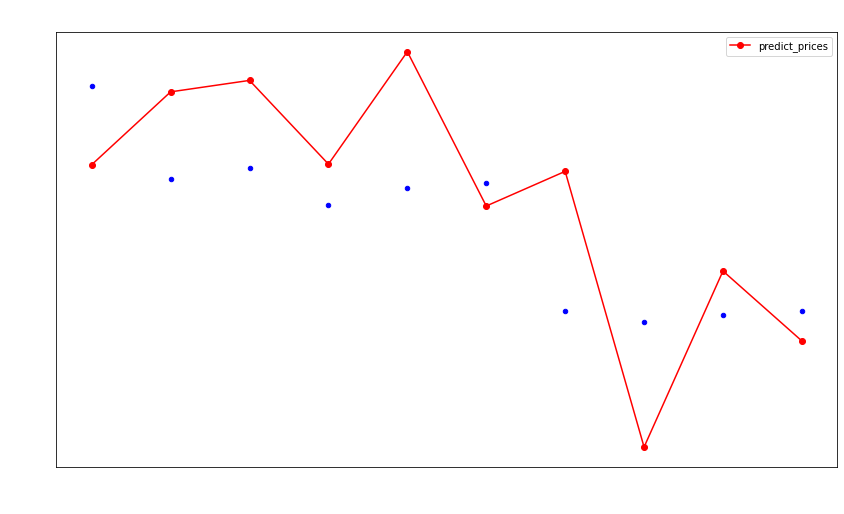

In [130]:
#loop through data set using a 10 fold technique looping 10 times to calculate over test accuracy over the last 10 day trend
counter=0
start=-1
test_values=9
mean_high = 0
highs = []
# define test dictionary for scatter plot
test_high_dic = {}
# define lists for scatter plot
results = []
predicts = []

while counter<10:
    #increase counter and indicies
    counter+=1
    start+=1
    test_values+=1
    # grab training data set 
    train_df = Stock_df.iloc[start:test_values]
    #grab test data for prediction
    predict_test = Stock_df["High"][test_values]
    #grab prediction inputs
    predict_inputs = train_df.tail(1)
    del predict_inputs["Open"]
    #set high forecast dataframe
    High_df = High_forecast_df(train_df)
    #make high forecast regression line
    Forecast_high_reg = Forecast_high_regression(High_df)
    #get test data prediction
    prediction = Forecast_high_reg.predict(predict_inputs)
    #analyze prediction with real data and add to statistics
    error = ((prediction[0]/predict_test)-1)*100
    #record error margin
    highs.append(error)
    mean_high+=error
    #adding to dictionary list
    predicts.append(prediction[0])
    results.append(predict_test)


#find mean and stdv
mean_high = mean_high/10
high_stdev = statistics.stdev(highs)
print("Regression Accuracy Over the Past 10 Time Periods")
print()
print(f"mean margin of error: {mean_high}%")
print(f"standard deviation of error: {high_stdev}%")
print(f"Deviation range: {mean_high-high_stdev}% - {mean_high+high_stdev}%")
print()

#set up dataframe
test_high_dic["predict_time"]= np.arange(1,11).tolist()
test_high_dic["predict_prices"] = predicts
test_high_dic["test_time"]= np.arange(1,11).tolist()
test_high_dic["test_prices"] = results
test_high_df = pd.DataFrame.from_dict(test_high_dic)

#make scatter plot showing test data and regression line 
high_reg_plot = test_high_df.plot(x='predict_time', y='predict_prices', color='r', marker='o')    
ax2 = test_high_df.plot(kind='scatter', x='test_time', y='test_prices', color='b', ax=high_reg_plot)    
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')
plt.xlabel("Time", fontsize=20, color='white')
plt.ylabel("High Prices", fontsize=20, color='white')
plt.title("Test Regression Resluts", fontsize=25, color='white')
plt.rcParams["figure.figsize"] = (14,8)
plt.show()

## Final Product Forecasted Prices
Here is the final product of the forecasting program, the regression lines are trained on the most recent 9 out of 10 weeks. The 10th week is the current week which is the input for our predictions for next week.  The program takes the accuracy in the previous 10 periods to give a saftey harnest around its predictions. In the chart below there is the high and low predictions for price including the saftey barrier which is the margin of error barrier protecting the trader from additional risk. As the trader, the red boundries represent your SELL or SHORT zone, the closer to the prediction price the better. The green boundries represent your BUY or LONG zone, the closer to the prediction price the better. Taking advantage of these zones you can make minimal risk trades to optimize your profits based on regression by simply buying in the green zone and selling in the red. 

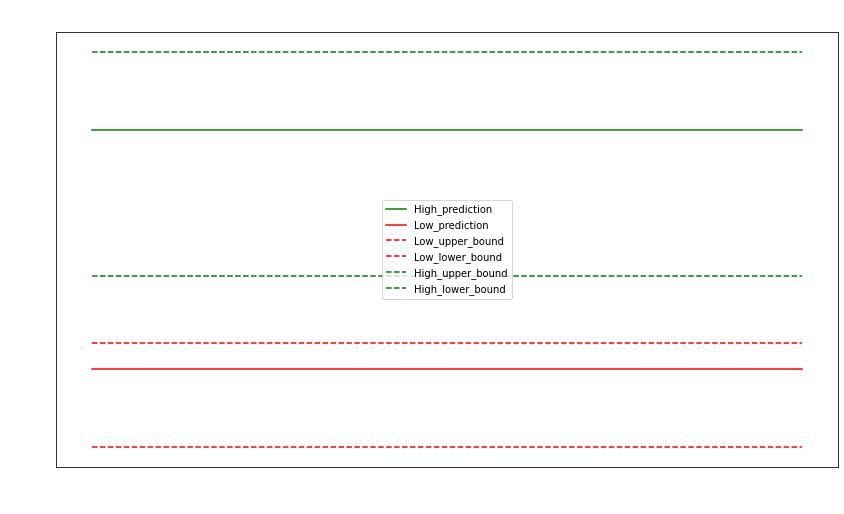

In [131]:
#set up dataframe
prediction_chart_dic = {}
prediction_chart_dic['Time'] = [0, 1, 2, 3, 4, 5]
#prediction high and low here 
train_df = Stock_df.iloc[len(Stock_df)-10:len(Stock_df)]
predict_inputs = Stock_df.tail(1)

#set forecast dataframes
Low_df = Low_forecast_df(train_df)
High_df = High_forecast_df(train_df)
#make forecast regression line
Forecast_low_reg = Forecast_low_regression(Low_df)
Forecast_high_reg = Forecast_high_regression(High_df)
#grab predictions
del predict_inputs["Open"]
prediction_low = Forecast_low_reg.predict(predict_inputs)
prediction_high = Forecast_high_reg.predict(predict_inputs)
#calculate the boundries here for list 
low_upper_b = prediction_low - (prediction_low*((mean_low/100)-(low_stdev/100)))/2
low_lower_b = prediction_low - (prediction_low*((mean_low/100)+(low_stdev/100)))/2
high_upper_b = prediction_high - (prediction_high*((mean_high/100)-(high_stdev/100)))/2
high_lower_b = prediction_high - (prediction_high*((mean_high/100)+(high_stdev/100)))/2
#add boundies to dataframe
prediction_chart_dic['High_prediction'] = [prediction_high[0]]*6
prediction_chart_dic['Low_prediction'] = [prediction_low[0]]*6
prediction_chart_dic['Low_upper_bound'] = [low_upper_b[0]]*6
prediction_chart_dic['Low_lower_bound'] = [low_lower_b[0]]*6
prediction_chart_dic['High_upper_bound'] = [high_upper_b[0]]*6
prediction_chart_dic['High_lower_bound'] = [high_lower_b[0]]*6
test_df = pd.DataFrame({ key:pd.Series(value) for key, value in prediction_chart_dic.items() })

#make scatter plot showing test data and regression line 
test_plot = test_df.plot(x='Time', y='High_prediction', color='g')  
ax = test_df.plot(x='Time', y='Low_prediction', color='r', ax=test_plot)
ax1 = test_df.plot(x='Time', y='Low_upper_bound', color='r', linestyle='dashed', ax=test_plot) 
ax2 = test_df.plot(x='Time', y='Low_lower_bound', color='r', linestyle='dashed', ax=test_plot) 
ax3 = test_df.plot(x='Time', y='High_upper_bound', color='g', linestyle='dashed', ax=test_plot) 
ax4 = test_df.plot(x='Time', y='High_lower_bound', color='g', linestyle='dashed', ax=test_plot)  
ax4.tick_params(axis='x', colors='white')
ax4.tick_params(axis='y', colors='white')
plt.xlabel("Time", fontsize=20, color='white')
plt.ylabel("Stock Prices", fontsize=20, color='white')
plt.title("Predicted Stock Prices", fontsize=25, color='white')
plt.rcParams["figure.figsize"] = (14,8)
plt.show()